In [656]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [657]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import time
import six
import glob
from stompy.plot import nbviz

In [658]:
# run_wy2022_bloom_common_20220810:
#   dye1, oakland release, non-temp hydro
# run_wy2022_bloom_common_20220810-v001
#   oakland, eastshore releases. temp hydro.
# run_wy2022_bloom_common_20220810-v002
#   oakland release, temp hydro, 16.62 integration
# run_wy2022_bloom_common_20220810-v003"
#   oakland release in top 2m of water column
# run_wy2022_bloom_common_20220515-v002
#   testing custom tracer
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers for continuous release.
# run_wy2022_bloom_common_20220705
#   age and depth tracers for continuous release, longer period w/ EBDA
#   EBDA exposure misconfigured
# run_wy2022_bloom_common_20220705-v001
#   fix EBDA exposure
# run_wy2022_bloom_common_20220705-v003
#   LSB exposure, age variance, 0.1/day decay of EBDA and LSB
#   has variance, but it's broken.
# run_wy2022_bloom_common_20220705-v004
#   Should have variance fixed now
run_dir="run_wy2022_bloom_common_20220705-v004"

In [659]:
ds=xr.open_dataset(os.path.join(run_dir,"dwaq_map.nc"))

In [660]:
# post process to get
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

<IPython.core.display.Javascript object>


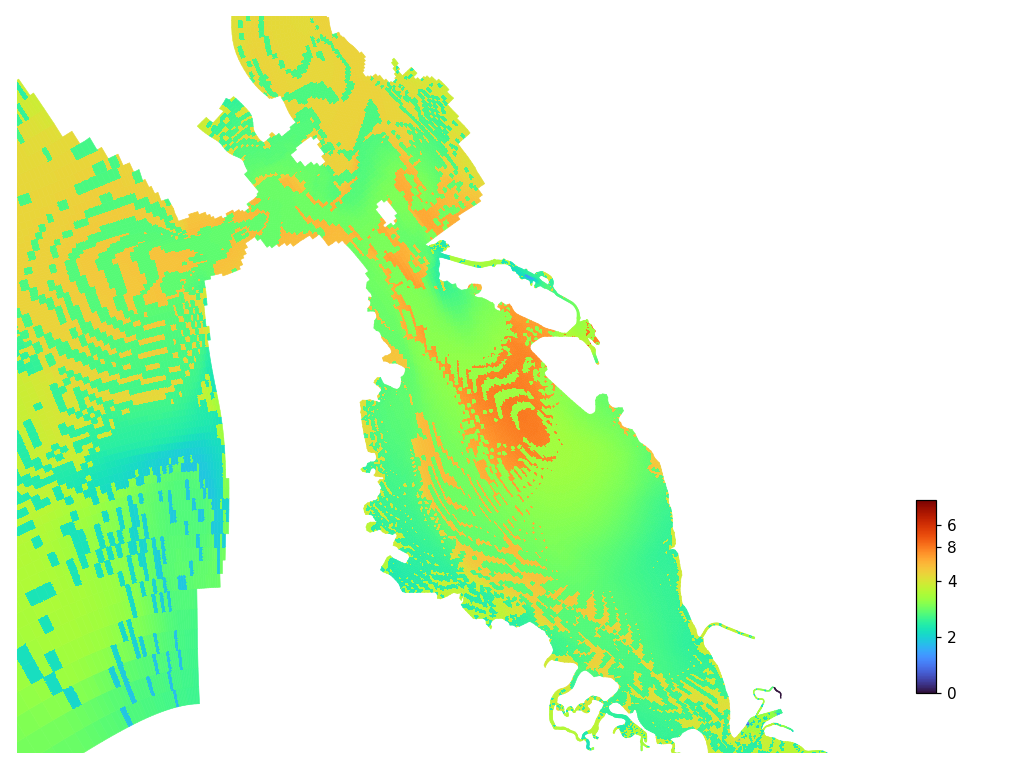

NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane


/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWar

In [678]:
six.moves.reload_module(nbviz)
# dev: eventually automate more of this.
def safe_ratio(numer,denom,thresh=1e-5):
    def func(src,dims):
        thresh=1e-5
        v_numer=src(numer,dims)
        v_denom=src(denom,dims)
        ratio=np.full(v_denom.shape,0.0)    
        return v_numer / v_denom.clip(thresh)
    return func

def stddev(conc,age_conc,var_conc):
    f_age=safe_ratio(age_conc,conc)
    f_mom2=safe_ratio(var_conc,conc)
    
    def func(src,dims,f_age=f_age,f_mom2=f_mom2):
        age=f_age(src,dims)
        mom2=f_mom2(src,dims)
        # unsure of the factor of 2 here.
        return np.sqrt( mom2-age*age/2 )
    return func

viz=nbviz.NBViz(
    [ds],
    expressions=[
      nbviz.BoundExpression(name='age',dims=['time','layer','face'],func=safe_ratio('Age1AConc','Age1Conc')),
      nbviz.BoundExpression(name='avg_depth',dims=['time','layer','face'],func=safe_ratio('Age1DAConc','Age1AConc')),
      nbviz.BoundExpression(name='avg_ebda',dims=['time','layer','face'],func=safe_ratio('Age1NAConc','Age1AConc')),
      nbviz.BoundExpression(name='expo_ebda',dims=['time','layer','face'],func=safe_ratio('Age1NAConc','Age1Conc')),
      nbviz.BoundExpression(name='avg_lsb',dims=['time','layer','face'],func=safe_ratio('Age1LAConc','Age1AConc')),
      nbviz.BoundExpression(name='expo_lsb',dims=['time','layer','face'],func=safe_ratio('Age1LAConc','Age1Conc')),
      nbviz.BoundExpression(name='age_stddev',dims=['time','layer','face'],
                            func=stddev('Age1Conc','Age1AConc','Age1VConc')),
    ])
                

viz

In [587]:
six.moves.reload_module(unstructured_grid)
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [548]:
frac=0.1
M=grid.smooth_matrix()

INFO:utils:80913/86633


In [549]:
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

In [550]:
# Is it not taking off b/c...
#   c0 too low relative max productivity?
#   light limitation too strong? I think this is it. Dropping Kd to 0.5 gets
#   bloom front, though
#   it's not nutrient limitation. It's not N0

/home/rusty/.conda/envs/general_rh/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


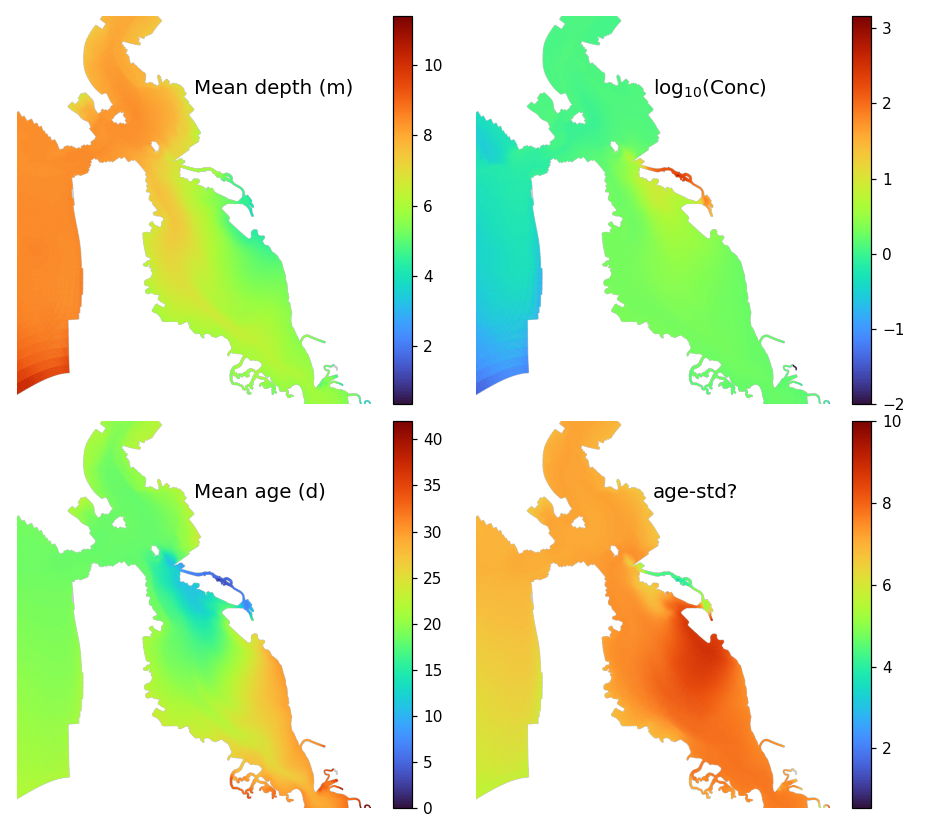

In [677]:
# Choose a time and show the tracer outputs
t=np.datetime64("2022-08-16")
layer=0

zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)

age_conc=ds['Age1AConc'].sel(time=t,method='nearest').isel(layer=0)
conc    =ds['Age1Conc'].sel(time=t,method='nearest').isel(layer=0)
age_depth_conc=ds['Age1DAConc'].sel(time=t,method='nearest').isel(layer=0)

max_age=(t-ds.time.values[0])/np.timedelta64(1,'D')
mean_age=ratio(age_conc,conc).clip(0,max_age)

mean_depth=ratio(age_depth_conc, age_conc)
valid=conc.values>=0.008 # covers to just N of DMB, and into Central Bay
H=mean_depth.values

var_conc=ds['Age1VConc'].sel(time=t,method='nearest').isel(layer=0)

scals=[mean_depth,np.log10(conc.clip(1e-2)),
       mean_age,
       #(mean_age**2/2).clip(0,500)
      ]
labels=['Mean depth (m)','log$_{10}$(Conc)','Mean age (d)']

#scals.append(var_conc)
#labels.append('Var.-conc')

#scals.append(ratio(var_conc,conc).clip(0,500))
#labels.append('2nd mom')

scals.append( np.sqrt( (ratio(var_conc,conc) - mean_age**2/2)).clip(0,10))
labels.append('age-std?')


fig,axs=plt.subplots(2,2,figsize=(8.5,7.5))

plt.setp(axs, adjustable='datalim')
for ax in axs.ravel():
    ax.axis('off')
fig.tight_layout()
for i,(ax,scal,label) in enumerate(zip(axs.ravel(),scals,labels)):
    grid.plot_cells(color='0.8',zorder=0,ax=ax)
    ccoll=grid.plot_cells(values=scal,mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                          edgecolor='face',lw=0.3)
    ax.axis(zoom)
    plt.colorbar(ccoll,ax=ax)

    ax.text(0.5,0.8,label,transform=ax.transAxes,fontsize=13)


In [736]:
# totally made up numbers to get a bloom over a week, and over
# 100 ug/l
from scipy.integrate import odeint

class Petri:
    I0=100. # insolation
    Isat=10.
    N0=35 # initial DIN
    Nsat=0.5
    Kd=1.0 # light extinction
    kmort=0.15 # per day
    kprod=1.2 # per day, max
    alpha=0.15 # stoichiometry, uM DIN per ug/l chl production.

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
    def diff(state,t,Hmean):
        P,N=state
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        Imean=self.I0*np.exp(-self.Kd*Hmean)
        kLight=Imean/(Imean+self.Isat)
        # duplicate while testing.
        kDIN=N/(N+self.Nsat)
        dgrossP = self.kprod*kLight*kDIN*P
        dnetP = -self.kmort*P + dgrossP
        dN = -self.alpha*dgrossP
        return np.r_[dnetP,dN]

    # t: days
    # c0: phytoplankton as chl ug/l
    # Hmean: meters
    def predict(self, c0, age, Hmean,N0=None):
        if N0 is None:
            N0=self.N0
            
        Imean=self.I0*np.exp(-self.Kd*Hmean)
        kLight=Imean/(Imean+self.Isat)
        #def diff(t,state):
        #    P,N=state
        #    N=N.clip(0)
        #    P=P.clip(0)
        #    kDIN=N/(N+self.Nsat)
        #    dgrossP = self.kprod*kLight*kDIN*P
        #    dnetP = -self.kmort*P + dgrossP
        #    dN = -self.alpha*dgrossP
        #    return np.r_[dnetP,dN]

        age=np.atleast_1d(age)
        if len(age)==1:
            t_vals=np.r_[0,age[0]] # linspace(0,15,200)
        else:
            t_vals=age
            
        params=np.array([self.Nsat,self.kprod*kLight,self.kmort,self.alpha])
        
        result=odeint(self.nb_diff,[c0,N0],t_vals,tfirst=True,
                      args=(params,))
        if len(age)==1:
            return result[-1,:]
        else:
            return result

    @staticmethod
    @njit
    def nb_diff(t,state,params):
        P=max(0,state[0]) # .clip(0)
        N=max(0,state[1]) # .clip(0)
        Nsat=params[0]
        k_prod_light=params[1]
        k_mort=params[2]
        alpha=params[3]
        
        kDIN=N/(N+params[0])
        dgrossP = k_prod_light*kDIN*P
        dnetP = -k_mort*P + dgrossP
        dN = -alpha*dgrossP
        return np.array([dnetP,dN])
        
    def predict_many(self,c0,age,Hmean,N0=None):
        if N0 is None:
            N0=self.N0
        N0=np.atleast_1d(N0)
            
        t_start=time.time()
        B=np.broadcast(c0,age,Hmean,N0)        
        result=np.zeros(B.shape+(2,),np.float64)
        resultR=result.reshape([-1,2])
        for c0,age,Hmean,N0 in B:
            resultR[B.index-1,:]=self.predict(c0,age,Hmean,N0)
        elapsed=time.time()-t_start
        print(f"Elapsed time for {B.size} samples: {elapsed:.3f}s")
        return result

In [561]:
# interesting region for the polygon release:
# source_strength=100 # tracer release is unit concentration. scale up to get source ug/l
# petri_args=dict(Kd=0.4)

zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)

petri=Petri()


# dynamic inputs
source_strength=0.1 # tracer release is unit concentration. scale up to get source ug/l
Kd=0.35
Nsat=1.0
c_thresh=0.008

t=np.datetime64("2022-08-19")
layer=0


age_conc=ds['Age1AConc'].sel(time=t,method='nearest').isel(layer=0)
conc    =ds['Age1Conc'].sel(time=t,method='nearest').isel(layer=0)
age_depth_conc=ds['Age1DAConc'].sel(time=t,method='nearest').isel(layer=0)

max_age=(t-ds.time.values[0])/np.timedelta64(1,'D')
mean_age=ratio(age_conc,conc).clip(0,max_age)
mean_depth=ratio(age_depth_conc, age_conc)


# post-hoc timing of release
release_start=np.datetime64("2022-08-02")
release_sigma_days=3

petri.Kd=Kd
petri.Nsat=Nsat

weight=1.0
if release_start is not None:
    # t0 for parcel relative to release
    t_relative=(t-release_start)/np.timedelta64(1,'D') - mean_age
    # gaussian fall off. That might be too broad, though.
    weight=np.where(t_relative>0,1.0, np.exp(- (t_relative/release_sigma_days)**2) )

c0=weight * source_strength * conc.values

valid=conc.values>=c_thresh # covers to just N of DMB, and into Central Bay
idxs=np.nonzero( valid)[0]
# select a random subset of idxs to actually simulate
idxs=idxs[np.random.random(len(idxs))<0.04]

# with continuous release the age is important.
# age=(ds.time.values[tidx] - ds.time.values[0])/np.timedelta64(1,'D') * np.ones_like(c0)
age=mean_age.values
H=mean_depth.values

predicted=np.full((ds.dims['face'],2),np.nan,np.float64)
predicted[idxs] = petri.predict_many(c0[idxs],age[idxs],H[idxs])

predicted[:,0]=fill(predicted[:,0])
predicted[:,1]=fill(predicted[:,1])

Elapsed time for 1902 samples: 1.045s


<IPython.core.display.Javascript object>


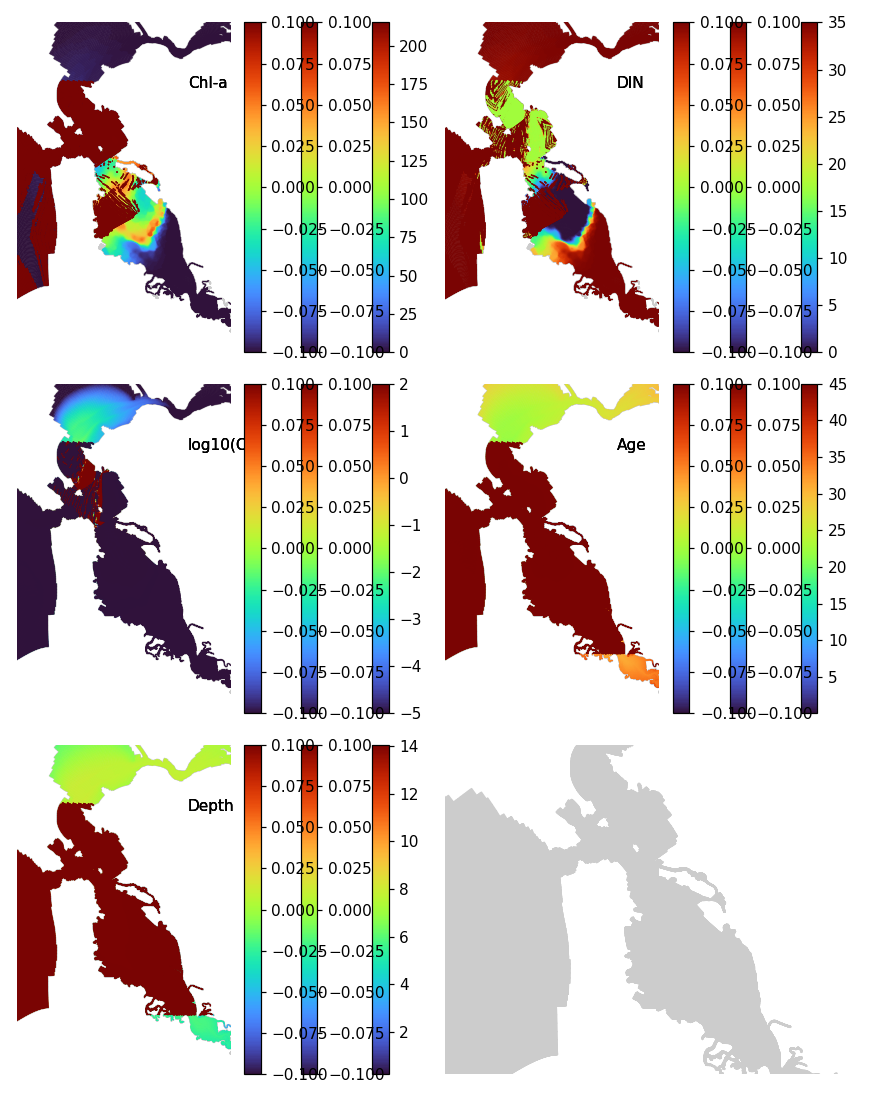

In [562]:
fig,axs=plt.subplots(3,2,figsize=(8,10))
plt.setp(axs, adjustable='datalim')

for ax in axs.ravel():
    ax.axis('off')
    grid.plot_cells(color='0.8',zorder=0,ax=ax)
fig.tight_layout()

    
for ax,scal,label in zip(axs.ravel(),
                        [predicted[:,0],predicted[:,1],
                         np.log10(c0.clip(1e-5)),
                         mean_age,
                         mean_depth],
                         ['Chl-a','DIN','log10(C0)','Age','Depth']):
    ccoll=grid.plot_cells(values=scal,
                          mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                          edgecolor='face',lw=0.3)
    plt.colorbar(ccoll,ax=ax)
    ax.text(0.8,0.8,label,transform=ax.transAxes)
    
    ax.axis(zoom)



In [744]:
# interesting region for the polygon release:
# source_strength=100 # tracer release is unit concentration. scale up to get source ug/l
# petri_args=dict(Kd=0.4)
from stompy import utils
from scipy import stats # norm

class LiveBloom:
    # dynamic inputs
    source_strength=0.1 # tracer release is unit concentration. scale up to get source ug/l
    Kd=0.35
    Nsat=1.0
    c_thresh=0.000
    t=np.datetime64("2022-08-16")
    layer=0
    # post-hoc timing of release
    release_start=np.datetime64("2022-08-02")
    release_sigma_days='auto' # 3
    frac=0.05
    
    ebda_factor=0.0
    
    # constant-ish
    zoom=(534866.147091273, 587089.832126076, 4151509.9875591, 4202696.11593758)
    background=False

    def __init__(self,ds):
        self.petri=Petri()
        self.ds=ds
        self.grid=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
        
        # the cell fields to be plotted
        self.conc=np.zeros(self.grid.Ncells())
        self.mean_age=np.zeros(self.grid.Ncells())
        self.mean_depth=np.zeros(self.grid.Ncells())
        
        self.predicted=np.zeros( (self.grid.Ncells(),2),np.float64)

        self.chl=self.predicted[:,0]
        self.din=self.predicted[:,1]
        
    def run(self):
        ds=self.ds
        t=self.t
        age_conc=ds['Age1AConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
        self.conc[:] = conc =ds['Age1Conc'].sel(time=t,method='nearest').isel(layer=self.layer).values
        age_depth_conc=ds['Age1DAConc'].sel(time=t,method='nearest').isel(layer=self.layer).values

        max_age=(t-ds.time.values[0])/np.timedelta64(1,'D')
        self.mean_age[:]=ratio(age_conc,conc).clip(0,max_age)
        self.mean_depth[:]=ratio(age_depth_conc, age_conc)
        
        self.petri.Kd=self.Kd
        self.petri.Nsat=self.Nsat

        weight=1.0
        if self.release_start is not None:
            # t0 for parcel relative to release
            t_relative=(t-self.release_start)/np.timedelta64(1,'D') - self.mean_age
            # gaussian fall off. That might be too broad, though.
            if self.release_sigma_days=='auto':
                # really this is 2nd moment-concentration.
                var_conc=ds['Age1VConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
                rel_sigma=((ratio(var_conc,conc)-self.mean_age**2/2).clip(0))**0.5
                self.std_age=rel_sigma
            else:
                rel_sigma=self.release_sigma_days
                self.std_age=None
            # not quite the right form. this pulls a probability density, but I want to
            # pull from the cumulative distribution.
            # weight=np.where(t_relative>0,1.0, np.exp(- (t_relative/rel_sigma)**2) )
            weight=stats.norm.cdf( t_relative, loc=0, scale=rel_sigma.clip(0.1))

        N0=35*np.ones_like(self.mean_age)
        if self.ebda_factor!=0.0:
            ebda_age_conc=ds['Age1NAConc'].sel(time=t,method='nearest').isel(layer=self.layer).values
            ebda_avg=ratio(ebda_age_conc,age_conc)
            N0+=ebda_avg*self.ebda_factor
            
        c0=weight * self.source_strength * self.conc
        self.c0=c0

        valid=c0>=self.c_thresh 
        idxs=np.nonzero(valid)[0]
        # select a random subset of idxs to actually simulate
        idxs=idxs[np.random.random(len(idxs))<self.frac]

        self.predicted[:,:] = np.nan
        self.predicted[idxs,:] = self.petri.predict_many(self.c0[idxs],self.mean_age[idxs],
                                                         self.mean_depth[idxs],N0=N0[idxs])
        self.predicted[:,0]=fill(self.predicted[:,0])
        self.predicted[:,1]=fill(self.predicted[:,1])

    fig=None
    text=None
    def figure(self,update=True):
        if self.fig is None:
            update=False

        clip=utils.expand_xxyy(self.zoom,0.3)

        if not update:
            self.fig,self.axs=plt.subplots(2,3,figsize=(9,7))
            plt.setp(self.axs, adjustable='datalim')

            for ax in self.axs.ravel():
                ax.axis('off')
                if self.background:
                    grid.plot_cells(color='0.8',zorder=0,ax=ax,clip=clip)
            self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,
                                     hspace=0.01,wspace=0.08)

        scals=[self.chl, self.din,
               np.log10(self.c0.clip(1e-5)),
               self.mean_age,
               self.mean_depth]
        labels=['Chl-a','DIN','log10(C0)','Age','Depth']
        
        if self.std_age is not None:
            scals.append(self.std_age.clip(0,0.4*np.nanmean(self.mean_age)))
            labels.append(r'$\sigma_{age}$')

        plots=list(zip(self.axs.ravel(),scals,labels))
        t_str=str(self.t)[:16]        
        
        if not update:
            self.ccolls=[]
            ax_txt=self.axs.ravel()[0]
            self.text=ax_txt.text(0.5,0.83,t_str,transform=ax_txt.transAxes)
            
            for ax,scal,label in plots:
                scal=np.where(np.isfinite(scal),scal,0.0)
                
                ccoll=grid.plot_cells(values=scal,clip=clip,
                                      mask=np.isfinite(scal),ax=ax,cmap='turbo',zorder=1,
                                      edgecolor='face',lw=0.3)
                plt.colorbar(ccoll,ax=ax)
                self.ccolls.append(ccoll)
                ax.text(0.5,0.75,label,transform=ax.transAxes)
                ax.axis(zoom)

        self.text.set_text(t_str)
        mask=grid.cell_clip_mask(clip,by_center=False)
            
        for ccoll,(ax,scal,label) in zip(self.ccolls,plots):
            ccoll.set_array(scal[mask])

Elapsed time for 2421 samples: 1.379s


<IPython.core.display.Javascript object>


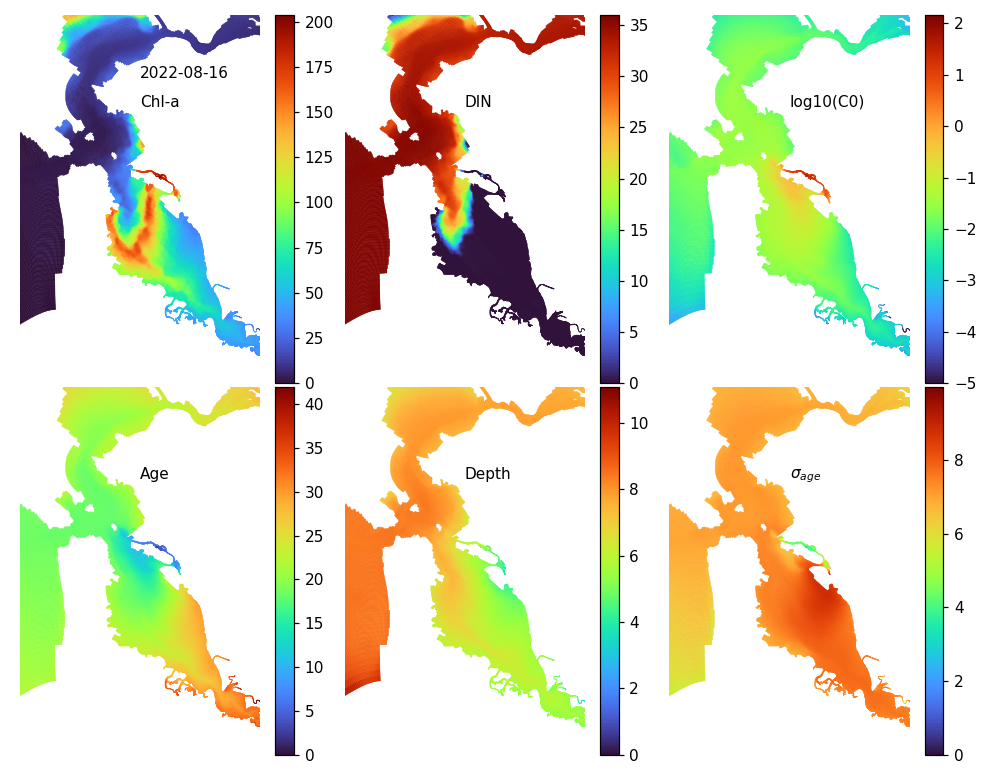

In [745]:
lb=LiveBloom(ds)
lb.ebda_factor=1.0
lb.run()
lb.figure()

Elapsed time for 2482 samples: 2.046s


<IPython.core.display.Javascript object>


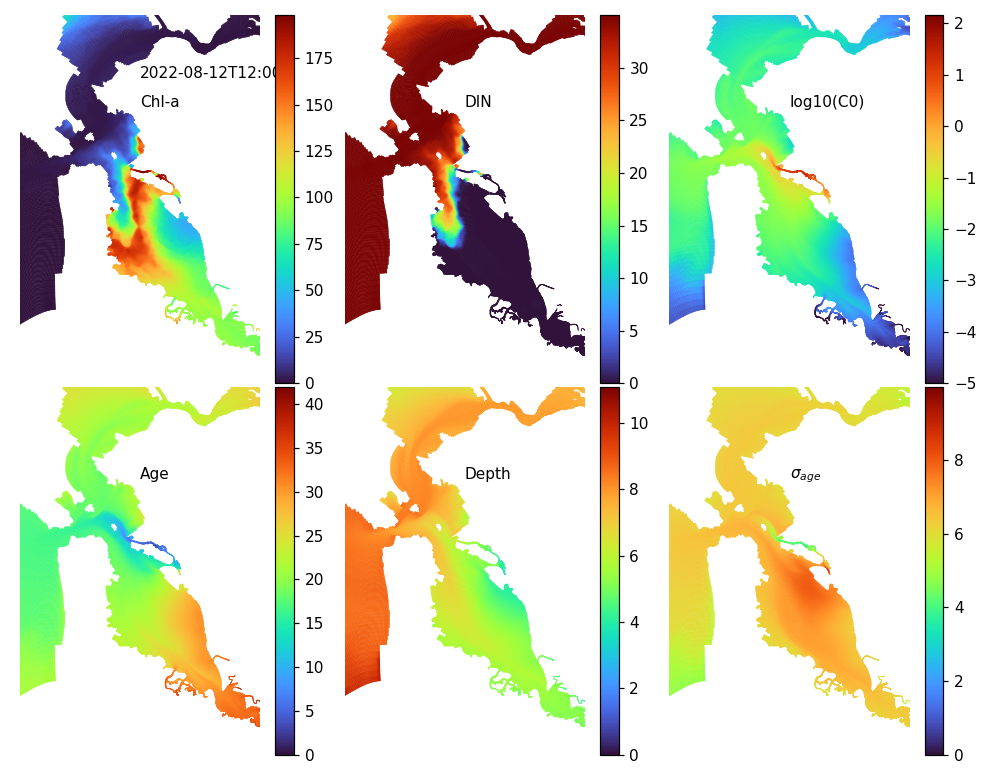

interactive(children=(FloatSlider(value=10.5, description='days', max=31.5, min=-10.5), FloatLogSlider(value=1…

<function __main__.run_and_plot(days=10.5, ebda_factor=1.0)>

In [746]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import datetime
lb=LiveBloom(ds)
lb.run()
lb.figure()

def run_and_plot(days=10.5,ebda_factor=1.0):
    lb.t=np.datetime64('2022-08-02')+days*np.timedelta64(86400,'s')
    lb.ebda_factor=ebda_factor
    lb.run()
    lb.figure()
    plt.draw()

interact(run_and_plot,
         t=widgets.DatePicker(value=datetime.datetime(2022,8,5,12,0)),
         ebda_factor=widgets.FloatLogSlider(value=1,base=10,min=-5,max=5,step=0.2,
                                            description="EBDA",continuous_update=False)
        )


In [653]:
# animation
frame_dir=os.path.join(run_dir,"frames-Kd0p35")
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
    
for i,t in enumerate(np.arange(np.datetime64("2022-08-02"),
                               np.datetime64("2022-08-22"),
                               np.timedelta64(1800,'s'))):
    img_fn=os.path.join(frame_dir,f"frame_{i:04d}.png")
    lb.t=t
    lb.run()
    lb.figure()
    lb.fig.savefig(img_fn)

Elapsed time for 9758 samples: 0.544s
Elapsed time for 9799 samples: 0.648s
Elapsed time for 9776 samples: 0.601s
Elapsed time for 9794 samples: 0.532s
Elapsed time for 9906 samples: 0.540s
Elapsed time for 9764 samples: 0.556s
Elapsed time for 9967 samples: 0.544s
Elapsed time for 9784 samples: 0.520s
Elapsed time for 9831 samples: 0.533s
Elapsed time for 9723 samples: 0.520s
Elapsed time for 9757 samples: 0.531s
Elapsed time for 9790 samples: 0.559s
Elapsed time for 9878 samples: 0.544s
Elapsed time for 9847 samples: 0.539s
Elapsed time for 9937 samples: 0.568s
Elapsed time for 9840 samples: 0.622s
Elapsed time for 9841 samples: 0.651s
Elapsed time for 9776 samples: 0.561s
Elapsed time for 9800 samples: 0.569s
Elapsed time for 9836 samples: 0.562s
Elapsed time for 9910 samples: 0.625s
Elapsed time for 9927 samples: 0.550s
Elapsed time for 9649 samples: 0.545s
Elapsed time for 9710 samples: 0.553s
Elapsed time for 9769 samples: 0.700s
Elapsed time for 9678 samples: 0.542s
Elapsed time

Elapsed time for 9975 samples: 0.795s
Elapsed time for 9854 samples: 0.688s
Elapsed time for 9912 samples: 0.700s
Elapsed time for 9859 samples: 0.711s
Elapsed time for 9790 samples: 0.679s
Elapsed time for 9851 samples: 0.712s
Elapsed time for 9855 samples: 0.728s
Elapsed time for 9948 samples: 0.772s
Elapsed time for 9948 samples: 0.741s
Elapsed time for 9950 samples: 0.691s
Elapsed time for 9797 samples: 0.828s
Elapsed time for 9781 samples: 0.766s
Elapsed time for 9757 samples: 0.789s
Elapsed time for 9718 samples: 0.672s
Elapsed time for 9951 samples: 0.883s
Elapsed time for 9788 samples: 0.730s
Elapsed time for 9767 samples: 0.658s
Elapsed time for 9763 samples: 0.829s
Elapsed time for 9959 samples: 0.774s
Elapsed time for 9743 samples: 0.700s
Elapsed time for 9864 samples: 0.709s
Elapsed time for 9642 samples: 0.694s
Elapsed time for 9855 samples: 0.880s
Elapsed time for 9828 samples: 0.720s
Elapsed time for 10015 samples: 0.731s
Elapsed time for 9902 samples: 0.737s
Elapsed tim

Elapsed time for 9915 samples: 1.128s
Elapsed time for 9914 samples: 0.990s
Elapsed time for 9858 samples: 0.988s
Elapsed time for 9773 samples: 0.968s
Elapsed time for 9883 samples: 1.077s
Elapsed time for 9898 samples: 1.083s
Elapsed time for 9856 samples: 1.041s
Elapsed time for 9888 samples: 1.014s
Elapsed time for 9774 samples: 1.036s
Elapsed time for 9905 samples: 1.107s
Elapsed time for 9765 samples: 1.014s
Elapsed time for 9820 samples: 1.044s
Elapsed time for 9804 samples: 1.139s
Elapsed time for 9771 samples: 1.022s
Elapsed time for 9742 samples: 1.059s
Elapsed time for 9769 samples: 1.393s
Elapsed time for 9636 samples: 1.004s
Elapsed time for 9899 samples: 1.043s
Elapsed time for 9769 samples: 1.025s
Elapsed time for 9758 samples: 0.997s
Elapsed time for 9935 samples: 1.002s
Elapsed time for 9927 samples: 1.031s
Elapsed time for 9901 samples: 1.020s
Elapsed time for 9998 samples: 1.023s
Elapsed time for 9839 samples: 0.985s
Elapsed time for 9980 samples: 1.012s
Elapsed time

Elapsed time for 9853 samples: 1.510s
Elapsed time for 9767 samples: 1.489s
Elapsed time for 9611 samples: 1.591s
Elapsed time for 9786 samples: 1.498s
Elapsed time for 10035 samples: 1.530s
Elapsed time for 9806 samples: 1.457s
Elapsed time for 9913 samples: 1.484s
Elapsed time for 9852 samples: 1.475s
Elapsed time for 9786 samples: 1.387s
Elapsed time for 9788 samples: 1.413s
Elapsed time for 9773 samples: 1.513s
Elapsed time for 9779 samples: 1.415s
Elapsed time for 9700 samples: 1.493s
Elapsed time for 9864 samples: 1.631s
Elapsed time for 9797 samples: 1.494s
Elapsed time for 9798 samples: 2.236s
Elapsed time for 9844 samples: 1.681s
Elapsed time for 9804 samples: 1.577s
Elapsed time for 9892 samples: 1.608s
Elapsed time for 9674 samples: 1.597s
Elapsed time for 9774 samples: 1.595s
Elapsed time for 9988 samples: 1.675s
Elapsed time for 9825 samples: 1.652s
Elapsed time for 9708 samples: 1.998s
Elapsed time for 9817 samples: 1.599s
Elapsed time for 9756 samples: 1.633s
Elapsed tim

Elapsed time for 9877 samples: 2.298s
Elapsed time for 9739 samples: 2.292s
Elapsed time for 9757 samples: 2.351s
Elapsed time for 9755 samples: 2.271s
Elapsed time for 9886 samples: 2.506s
Elapsed time for 9635 samples: 2.390s
Elapsed time for 9611 samples: 2.399s
Elapsed time for 9758 samples: 2.289s
Elapsed time for 9618 samples: 2.280s
Elapsed time for 9845 samples: 2.382s
Elapsed time for 9843 samples: 2.278s
Elapsed time for 9779 samples: 2.287s
Elapsed time for 9868 samples: 2.529s
Elapsed time for 9825 samples: 2.338s
Elapsed time for 9779 samples: 2.243s
Elapsed time for 9774 samples: 2.377s
Elapsed time for 9881 samples: 2.275s
Elapsed time for 9611 samples: 2.163s
Elapsed time for 10035 samples: 2.251s
Elapsed time for 9973 samples: 2.385s
Elapsed time for 9837 samples: 2.246s
Elapsed time for 9824 samples: 2.242s
Elapsed time for 9900 samples: 2.359s
Elapsed time for 9686 samples: 2.300s
Elapsed time for 9765 samples: 2.408s
Elapsed time for 9880 samples: 2.555s
Elapsed tim

In [654]:
# Compile to animation
movie_fn=os.path.join(frame_dir+"-v2.mp4")
if os.path.exists(movie_fn):
    os.unlink(movie_fn)
subprocess.run(f"ffmpeg -framerate 16 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
               f"-pix_fmt yuv420p -crf 20 -r 16 {movie_fn}",
               shell=True)
              

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args='ffmpeg -framerate 16 -i run_wy2022_bloom_common_20220705-v003/frames-Kd0p35/frame_%04d.png -c:v libx264 -preset slow -profile:v high -level:v 4.0 -pix_fmt yuv420p -crf 20 -r 16 run_wy2022_bloom_common_20220705-v003/frames-Kd0p35-v2.mp4', returncode=0)

In [655]:
Video(movie_fn)